# Preparation

**First**, you need to **load your google drive**.

By default, your root path is on temperal device and your data will be cleaned once you disconnect with the google device.

Google drive is recommened, or you need to download what you need manually.

**And, switch to the GPU mode!**
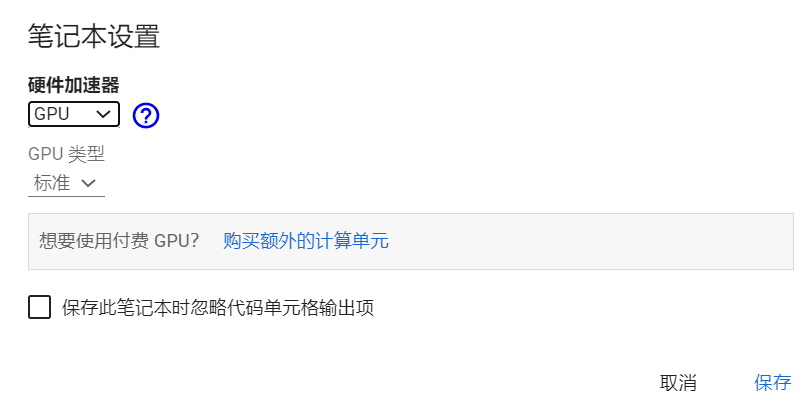

**Second, switch to your project root path:**

In [1]:
%cd '/content/drive/MyDrive/5018Project_MCTACO/' 

/content/drive/MyDrive/5018Project_MCTACO


## Packages Installation

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 29.4 MB/s eta 0:00:00


## Import

In [3]:
# numpy
import numpy as np

# pandas
import pandas as pd

# torch
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

# random
import random

# json
import json

# os
import os

# transformers(hugging face)
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from transformers.trainer_pt_utils import get_parameter_names
from transformers.optimization import Adafactor, get_scheduler

# sklearn
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import shuffle as sk_shuffle

# tqdm
from tqdm import tqdm

# warnings
import warnings
warnings.filterwarnings("ignore")   # mute all the warnings

# Settings

In [12]:
settings={
    'model_name':'bert-base-uncased',
    'dataset':'CommensenseQA',

    'continue':False,
    'checkpoint':'./checkpoint/',
    'from_pretrained':'bert-base-uncased_best', # model path under dir checkpoint 

    'num_choices':5,
    'weight_decay':0.0,
    'adam_epsilon':1e-8,
    'learning_rate':3e-6,
    'epochs':5,
    'eval_batch_size':15,
    'train_batch_size':15,
    'shuffle':False,
}

# Models
Reference/ Official document:

[AutoModel](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification)

[AutoModelForSequenceClassification](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification)

## RoBERTa

[RoBERTA Hugging Face Reference](https://huggingface.co/transformers/v3.0.2/model_doc/roberta.html#transformers.RobertaForSequenceClassification)

In [4]:
class RoBERTa(nn.Module):
    def __init__(
        self,
        name: str,      # model name
        num_choices: int,   # output dimensions
        settings
    ):
        super().__init__()
        
        self.name = name
        self.num_choices = num_choices
        self.max_length = 512

        # initialize tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(name, use_fast=True)

        # initialize model
        if settings['continue']:
            path = settings['checkpoint']+settings['from_pretrained']
            print("Loading from pretrained...")
            self.model = AutoModelForSequenceClassification.from_pretrained(path)
        else:
            print("Loading new model...")
            self.model = AutoModelForSequenceClassification.from_pretrained(name)
        
        # loss function
        self.ce_loss_func = nn.CrossEntropyLoss() # input:(batch_size, num_of_class)

    def save_pretrained(self, path):
        """
        desc:
            save trained model to self-defined path
        """
        self.model.save_pretrained(path, from_pt=True)
        print(f"model saved at {path}")
        
    def score_input(self, content):
        """
        desc:
            feed content to the language model
            return the logits
        """
        batch = self.tokenizer(
            content, padding=True, truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        out = self.model(
            batch["input_ids"].to(self.model.device), batch["attention_mask"].to(self.model.device),
            output_hidden_states=True
        )
        return out["logits"]

    def forward(self, batch):
        """
        desc:
        return:
            preds       unclear so far, considering to remove
            preds_cls     predicted class, for batch size=8, return predicted label list [1,0,1...] len = 8
            loss
        """
        content, labels  = batch
        logits = self.score_input(content)

        #print("logit", logits)

        labels = torch.tensor(labels, dtype=torch.long).to(logits.device)
        #print("labels", labels)
        loss = self.ce_loss_func(logits, labels)
        #print("loss", loss)
        preds_cls = list(torch.argmax(logits, 1).cpu().numpy())
        #print("preds_cls", preds_cls)
        positive_logits = logits[:, 1]
        #print("positive_logits", positive_logits)
        
        preds = torch.argmax(positive_logits.reshape(-1, self.num_choices), 1)
        preds = list(preds.cpu().numpy())
        return loss, preds, preds_cls

# Dataset

In [5]:
class CommonsenseQADataset(Dataset):
    def __init__(self, f, sep_token, input_format, shuffle):
        content, labels = [], []
        x = open(f).readlines()
        if shuffle:
            random.shuffle(x)
        
        for line in x:
            instance = json.loads(line)
            question = instance["question"]["stem"]
            choices = [item["text"] for item in instance["question"]["choices"]]
            if "answerKey" in instance:
                l = instance["answerKey"]
            else:
                l = "A"
            
            if input_format == "0":
                for c in choices:
                    content.append("{} {}".format(question, c))
            elif input_format == "1":
                for c in choices:
                    content.append("{} \\n {}".format(question, c))
            
            if l == "A":
                labels += [1, 0, 0, 0, 0]
            elif l == "B":
                labels += [0, 1, 0, 0, 0]
            elif l == "C":
                labels += [0, 0, 1, 0, 0]
            elif l == "D":
                labels += [0, 0, 0, 1, 0]
            elif l == "E":
                labels += [0, 0, 0, 0, 1]
                
        self.content, self.labels = content, labels
        
    def __len__(self):
        return len(self.content)

    def __getitem__(self, index):
        s1, s2 = self.content[index], self.labels[index]
        return s1, s2
    
    def collate_fn(self, data):
        dat = pd.DataFrame(data)
        return [dat[i].tolist() for i in dat]

## dataloader function

In [8]:
def configure_dataloaders(sep_token, train_batch_size=settings['train_batch_size'], eval_batch_size=settings['eval_batch_size'], shuffle=False, input_format="1"):
    "Prepare dataloaders"
    train_dataset = CommonsenseQADataset("./data/csqa/train.jsonl", sep_token, input_format, True)
    train_loader = DataLoader(train_dataset, shuffle=shuffle, batch_size=train_batch_size, collate_fn=train_dataset.collate_fn)

    val_dataset = CommonsenseQADataset("./data/csqa/valid.jsonl", sep_token, input_format, False)
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=eval_batch_size, collate_fn=val_dataset.collate_fn)
    
    test_dataset = CommonsenseQADataset("./data/csqa/test.jsonl", sep_token, input_format, False)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=eval_batch_size, collate_fn=val_dataset.collate_fn)

    return train_loader, val_loader, test_loader

# Training

## optimizer

In [9]:
def configure_optimizer(model, settings):
    """
    desc:
        Prepare optimizer and schedule (linear warmup and decay)
    """
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": settings['weight_decay'],
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]

    # Initialize optimizer: AdamW by default
    optimizer = AdamW(
        optimizer_grouped_parameters, 
        lr=settings['learning_rate'], 
        eps=settings['adam_epsilon']
        )
    return optimizer

## train for one epoch

In [10]:
def train_or_eval_model(model, dataloader, optimizer=None, split="Train"):
    """
    desc:
        function for execute train/validation/test in one epoch

    """
    losses, preds, preds_cls, labels_cls,  = [], [], [], []
    if split=="Train":
        model.train()
    else:
        model.eval()
    
    for batch in tqdm(dataloader, leave=False):
        if split=="Train":
            optimizer.zero_grad()
            
        content, l_cls = batch
        loss, p, p_cls = model(batch)
        
        preds.append(p)
        preds_cls.append(p_cls)
        labels_cls.append(l_cls)
        
        if split=="Train":
            loss.backward()
            optimizer.step()
            
        losses.append(loss.item())

    avg_loss = round(np.mean(losses), 4)
    
    if split=="Train":
        #wandb.log({"Train Loss": avg_loss})
        all_preds_cls = [item for sublist in preds_cls for item in sublist]
        all_labels_cls = [item for sublist in labels_cls for item in sublist]
        acc = round(accuracy_score(all_labels_cls, all_preds_cls), 4)
        f1 = round(f1_score(all_labels_cls, all_preds_cls, average="macro"), 4)
        #wandb.log({"Train CLS Accuracy": acc})

        return avg_loss, acc, f1
    
    elif split=="Val":
        #wandb.log({"Val Loss": avg_loss})
        all_preds_cls = [item for sublist in preds_cls for item in sublist]
        all_labels_cls = [item for sublist in labels_cls for item in sublist]
        acc = round(accuracy_score(all_labels_cls, all_preds_cls), 4)
        f1 = round(f1_score(all_labels_cls, all_preds_cls, average="macro"), 4)
        #wandb.log({"Val CLS Accuracy": acc})
        
        instance_preds = [item for sublist in preds for item in sublist]
        instance_labels = np.array(all_labels_cls).reshape(-1, settings['num_choices']).argmax(1)
        instance_acc = round(accuracy_score(instance_labels, instance_preds), 4)
        #wandb.log({"Val Instance Accuracy": instance_acc})
        
        return avg_loss, acc, instance_acc, f1
    
    elif "Test" in split:
        instance_preds = [item for sublist in preds for item in sublist]
        instance_preds = [str(item) for item in instance_preds]
        print ("Test preds frequency:", dict(pd.Series(instance_preds).value_counts()))

        return instance_preds

## main

In [11]:
# Initialize model

model = RoBERTa(
    name = settings['model_name'],
    num_choices=settings['num_choices'],
    settings = settings
).cuda()

Loading new model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [13]:
sep_token = model.tokenizer.sep_token

# Initialize optimizer
optimizer = configure_optimizer(model, settings)

#wandb.init(project="project_name_here" + sp)
#wandb.watch(model)

epochs  = settings['epochs']

best_val = 0

for e in range(epochs):
    train_loader, val_loader, test_loader = configure_dataloaders(sep_token)
    
    train_loss, train_acc, train_f1 = train_or_eval_model(model, train_loader, optimizer, "Train")
    val_loss, val_acc, val_ins_acc, val_f1 = train_or_eval_model(model, val_loader, split="Val")
    test_preds = train_or_eval_model(model, test_loader, split="Test")
    
    x = "Epoch {}: Loss: Train {}; Val {}".format(e+1, train_loss, val_loss)
    y1 = "Classification Acc: Train {}; Val {}".format(train_acc, val_acc)
    y2 = "Classification Macro F1: Train {}; Val {}".format(train_f1, val_f1)
    z = "Instance Acc: Val {}".format(val_ins_acc)
        
    print (x)
    print (y1)
    print (y2)
    print (z)

    if best_val < val_acc:
        best_val = val_acc
        model.save_pretrained(settings['checkpoint'] + f"{settings['model_name']}_best")
        print("-----------------------model_saved!------------------------------")



Test preds frequency: {'3': 246, '4': 243, '0': 222, '1': 215, '2': 214}
Epoch 1: Loss: Train 0.4874; Val 0.459
Classification Acc: Train 0.7998; Val 0.7993
Classification Macro F1: Train 0.4466; Val 0.4606
Instance Acc: Val 0.4242
model saved at ./checkpoint/bert-base-uncased_best
-----------------------model_saved!------------------------------


Test preds frequency: {'0': 233, '4': 233, '2': 232, '3': 227, '1': 215}
Epoch 2: Loss: Train 0.4477; Val 0.4484
Classification Acc: Train 0.8005; Val 0.7949
Classification Macro F1: Train 0.5054; Val 0.6183
Instance Acc: Val 0.4734


Test preds frequency: {'4': 235, '0': 231, '2': 228, '1': 223, '3': 223}
Epoch 3: Loss: Train 0.4103; Val 0.4435
Classification Acc: Train 0.8124; Val 0.7956
Classification Macro F1: Train 0.6086; Val 0.6356
Instance Acc: Val 0.4906


Test preds frequency: {'4': 242, '0': 235, '2': 224, '1': 220, '3': 219}
Epoch 4: Loss: Train 0.376; Val 0.469
Classification Acc: Train 0.8267; Val 0.7656
Classification Macro F1: Train 0.6736; Val 0.6508
Instance Acc: Val 0.4873


Test preds frequency: {'2': 241, '1': 229, '4': 224, '0': 223, '3': 223}
Epoch 5: Loss: Train 0.342; Val 0.4858
Classification Acc: Train 0.8435; Val 0.7772
Classification Macro F1: Train 0.7249; Val 0.6563
Instance Acc: Val 0.4922


# 新段落

In [ ]:
model.save_pretrained(settings['checkpoint'] + f"{settings['model_name']}_best")

model saved at ./checkpoint/roberta-large_best
